In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.optim as optim
import torchvision.datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from torch.autograd import Variable

from torch.optim import lr_scheduler

import time
import os
import copy

Working with images

In [4]:
transfroms_train = transforms.Compose(
    [
     transforms.Resize((224, 224), interpolation=3),
     transforms.ColorJitter(), # data augmentation: colors
     transforms.RandomHorizontalFlip(p=0.2), # data augmentation: random horizontal flipping
     transforms.RandomRotation(20), # data augmentation: rotation
     transforms.ToTensor(),
     transforms.Normalize(
         mean=[0.482, 0.458, 0.407],
         std=[0.229, 0.224, 0.225]
     )
    ]
)
transfroms_val_test = transforms.Compose(
    [
     transforms.Resize((224, 224), interpolation=3),
     transforms.ToTensor(),
     transforms.Normalize(
         mean=[0.482, 0.458, 0.407],
         std=[0.229, 0.224, 0.225]
     )
    ]
)

In [11]:
!unzip /content/drive/My\ Drive/Data.zip

Archive:  /content/drive/My Drive/Data.zip
   creating: Data/
   creating: Data/test/
   creating: Data/test/car/
  inflating: Data/test/car/100093.JPEG  
  inflating: Data/test/car/100132.JPEG  
  inflating: Data/test/car/100386.JPEG  
  inflating: Data/test/car/100422.JPEG  
  inflating: Data/test/car/100426.JPEG  
  inflating: Data/test/car/100508.JPEG  
  inflating: Data/test/car/100517.JPEG  
  inflating: Data/test/car/100598.JPEG  
  inflating: Data/test/car/100627.JPEG  
  inflating: Data/test/car/100750.JPEG  
  inflating: Data/test/car/100762.JPEG  
  inflating: Data/test/car/100901.JPEG  
  inflating: Data/test/car/100923.JPEG  
  inflating: Data/test/car/100931.JPEG  
  inflating: Data/test/car/100946.JPEG  
  inflating: Data/test/car/101035.JPEG  
  inflating: Data/test/car/101153.JPEG  
  inflating: Data/test/car/101264.JPEG  
  inflating: Data/test/car/101305.JPEG  
  inflating: Data/test/car/101411.JPEG  
  inflating: Data/test/car/101500.JPEG  
  inflating: Data/test/ca

In [5]:
train_set = torchvision.datasets.ImageFolder('/content/Data/train', 
                                             transfroms_train)
print("train_set: ", len(train_set))

train_set:  2709


In [6]:
test_set = torchvision.datasets.ImageFolder('/content/Data/test', 
                                            transfroms_val_test)
print("test_set: ", len(test_set))

test_set:  900


In [7]:
test_size = int(0.7 * len(test_set))
valid_size = len(test_set) - test_size
test_dataset, valid_dataset = torch.utils.data.random_split(test_set, [test_size, valid_size])

batch_size = 64

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            pin_memory=True, shuffle = True,
                                            num_workers=0)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=8,
                                            num_workers=0)
testloader = torch.utils.data.DataLoader(test_set, batch_size=16, 
                                            num_workers=0)

print("train_sampler: ", len(train_set))
print("valid_sampler: ", len(valid_dataset))
print("test_set: ", len(test_dataset))

train_sampler:  2709
valid_sampler:  270
test_set:  630


In [8]:
classes = ('car', 'human', 'noise')

Defining a convolutional neural network

I took the network as a basis:
https://github.com/pytorch/vision/pull/678/files

In [9]:
class GoogLeNet(nn.Module):  # It is good to use when there are limitations in memory or you need to use realtime
    def __init__(self, num_classes=3):
        super(GoogLeNet, self).__init__()

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3) # Convolution
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True) #  Max Pooling
        self.conv2 = BasicConv2d(64, 64, kernel_size=1) # Convolution
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(64, 64, 96, 128, 16, 32, 32)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4b = Inception(224, 160, 112, 224, 24, 64, 64)
        self.inception4e = Inception(448, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5b = Inception(704, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # averege pooling
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(896, num_classes) # Classification

    def forward(self, x):
        # type: (Tensor) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)
        
        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)

        # N x 512 x 14 x 14
        x = self.inception4b(x)
        # N x 528 x 14 x 14
        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        
        # N x 832 x 7 x 7
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

class Inception(nn.Module):  # Inception block applies convolutions of different sizes on the given layer and the result is glued into the resulting vector
                              # To pull out features of different scales. If the scale is too large for the current level, it is recognized at the next one.

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        # 1x1 conv branch 
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1) # In GoogLeNet, 1 × 1 convolution is used as a downsizing unit to reduce computation. 

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        
        # 3x3 pool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch4]
        return torch.cat(outputs, 1)

class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001) # Allows us to use much higher learning rates and be less attentive to initialization

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True) # The activation function determines the output value of the neuron depending on the result of the weighted sum of the inputs and the threshold value.
                                       # Introduces non-linearity to the network. ReLU is not subject to saturation, significantly increases the convergence rate of stochastic gradient descent

Network launch

In [10]:
model = GoogLeNet()
model = model.cuda()

Network Speed Metering

In [13]:
# cuDnn configurations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

model.eval()

x = torch.rand(1, 3, 224, 224).cuda()

time_list = []
for i in range(10001):
    torch.cuda.synchronize()
    tic = time.time()
    model(x)
    torch.cuda.synchronize()
    # The time for the first iteration is much higher, so eliminate the first iteration
    time_list.append(time.time()-tic)
time_list = time_list[1:]
print("     + Done 1000 iterations inference !")
print("     + Frame Per Second: {:.2f}".format(1/(sum(time_list)/1000)))

     + Done 1000 iterations inference !
     + Frame Per Second: 31.79


**Result of the Original Network** Frame Per Second: 13.94

Converting a model to ONNX

In [ ]:
import io
import torch.onnx

# Entering the model
x = torch.zeros(1, 3, 224, 224).cuda()
print(model(x))

# Export model
torch.onnx.export(model, # Running the model
                  x, # Multiple input tuple
                  'model.onnx', # File where to save the model
                  verbose=True) # Store trained parameter weights inside the model file

tensor([[0.0097, 0.0309, 0.0167]], device='cuda:0', grad_fn=<AddmmBackward>)
graph(%input.1 : Float(1, 3, 224, 224),
      %conv1.conv.weight : Float(64, 3, 7, 7),
      %conv1.bn.weight : Float(64),
      %conv1.bn.bias : Float(64),
      %conv1.bn.running_mean : Float(64),
      %conv1.bn.running_var : Float(64),
      %conv1.bn.num_batches_tracked : Long(),
      %conv2.conv.weight : Float(64, 64, 1, 1),
      %conv2.bn.weight : Float(64),
      %conv2.bn.bias : Float(64),
      %conv2.bn.running_mean : Float(64),
      %conv2.bn.running_var : Float(64),
      %conv2.bn.num_batches_tracked : Long(),
      %inception3a.branch1.conv.weight : Float(64, 64, 1, 1),
      %inception3a.branch1.bn.weight : Float(64),
      %inception3a.branch1.bn.bias : Float(64),
      %inception3a.branch1.bn.running_mean : Float(64),
      %inception3a.branch1.bn.running_var : Float(64),
      %inception3a.branch1.bn.num_batches_tracked : Long(),
      %inception3a.branch2.0.conv.weight : Float(96, 64, 1,

Defining the loss function and optimizer

In [14]:
loss_train = []
acc_train = []

num_epochs= 40
lr = 0.01 # 64 batch == 0.01, 128 batch == 0.1 

since = time.time()
val_acc_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Optimization is error minimization
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # SGD — stochastic, therefore, the movement does not occur in the direction of the gradient of the objective function of the error, 
                                                               # and in the direction of the error gradient from a random subsample. Consider adding a normally distributed noise to the actual gradient. 
                                                               # It is this noise that allows one to get out of the local minima.

criterion = torch.nn.CrossEntropyLoss() #  used to estimate the parameters of models, the difference between the estimated and true values
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs) # When training deep neural networks, it is often helpful to slow down the learning rate during the learning process.
                                                                        # CosineAnnealingLR allows you to start with a high learning rate,
                                                                        # which decreases relatively quickly to the minimum value, and then increases sharply again.

Network training + validation

In [ ]:
!pip3 install torch==1.5.0+cu100 torchvision==0.6.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [16]:
for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print('-' * 10)
    
    model.train(True)
    total_train = 0
    correct_train = 0
    for i, data in enumerate(trainloader):                        
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        # backward + optimization
        # moves incorrect information from the end of the network to all weights inside, 
        # so that another algorithm can already optimize these weights so that they fit the data
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_train += labels.size(0)
        correct_train += torch.sum(predicted == labels.data)
        
        del inputs, labels, outputs, predicted
        torch.cuda.empty_cache()

    # Statistics
    print('Network Accuracy in Training Images: %f %%' % (100 * correct_train / total_train))

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            inputs, labels = data            
            inputs, labels = inputs.cuda(), labels.cuda()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            del inputs, labels, outputs, predicted
            torch.cuda.empty_cache()

        # Statistics
        val_res = correct_val / total_val
        
        print('Neatness of the network on validation images: %f %%' % (100 * val_res))
        print('-' * 10)
        print()

        # Model copy
        if val_res > best_acc:
            best_acc = val_res
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), '_best_val_model.pth')
        val_acc_history.append(val_res)
    
elapsed_time = time.time() - since
print()
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

Epoch 1/40
----------
Network Accuracy in Training Images: 94.000000 %
Neatness of the network on validation images: 89.259259 %
----------

Epoch 2/40
----------
Network Accuracy in Training Images: 93.000000 %
Neatness of the network on validation images: 96.296296 %
----------

Epoch 3/40
----------
Network Accuracy in Training Images: 94.000000 %
Neatness of the network on validation images: 96.296296 %
----------

Epoch 4/40
----------
Network Accuracy in Training Images: 95.000000 %
Neatness of the network on validation images: 97.407407 %
----------

Epoch 5/40
----------
Network Accuracy in Training Images: 95.000000 %
Neatness of the network on validation images: 88.148148 %
----------

Epoch 6/40
----------
Network Accuracy in Training Images: 97.000000 %
Neatness of the network on validation images: 97.407407 %
----------

Epoch 7/40
----------
Network Accuracy in Training Images: 96.000000 %
Neatness of the network on validation images: 97.777778 %
----------

Epoch 8/40
--

Testing the network using test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


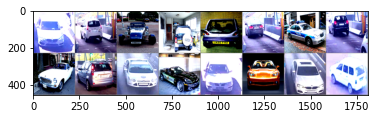

GroundTruth:    car   car   car


In [17]:
# Function for displaying images
def imshow(img):
    img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', 
      ' '.join('%5s' % classes[labels[j]] for j in range(3)))

The network operates on a whole dataset.

In [18]:
weights_best=torch.load('_best_val_model.pth')
model.load_state_dict(weights_best)

correct = 0
total = 0
model.eval()
with torch.no_grad():
    for it, (images, labels) in enumerate(testloader):
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Network Accuracy on Test Images: %f %%' % ( 
    100 * correct / total))

Network Accuracy on Test Images: 99.333333 %


In which classes the predictions performed well:

In [ ]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for it, (images, labels) in enumerate(testloader):
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))